In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

In [86]:
data_dir="../levelups_panel_20240722.csv"
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
108,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
109,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
110,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
111,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
112,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466396,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466397,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466398,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466399,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [87]:
# player_slug의 고유 값 수 계산
unique_player_count = data['player_slug'].nunique()

# 결과 출력
print(unique_player_count)

7279


In [88]:
data.columns

Index(['player_slug', 'character_slug', 'first_session_level', 'binger',
       'total_purchase', 'total_ad', 'highest_level', 'status', 'level_from',
       'level_to', 'event_datetime', 'death', 'ad_revival', 'ad_item',
       'ad_total', 'purchase', 'event_datetime_prev', 'interval',
       'interval_cum', 'playtime_boss', 'playtime_dungeon', 'playtime_tower',
       'playtime_pvp', 'playtime_farm', 'playtime_survival', 'playtime_side',
       'date_event', 'date_event_prev', 'same_date', 'date_interval', 'binge'],
      dtype='object')

## level_to 별 interval

In [89]:
# 'level_to' 값별로 'date_interval' 값의 평균 계산
level_to_interval_avg = data.groupby('level_to')['interval'].mean()


In [90]:
level_to_interval_avg

level_to
2      0.016455
3      0.007387
4      0.015077
5      0.018066
6      0.025615
         ...   
96     0.087961
97     0.054204
98     0.076918
99     0.188737
100    0.217671
Name: interval, Length: 99, dtype: float64

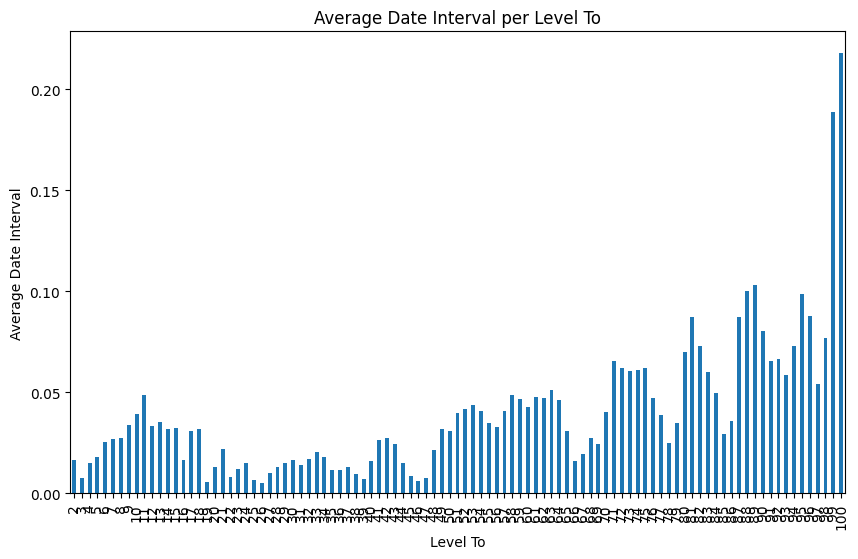

In [91]:
import matplotlib.pyplot as plt

# 바 플롯 생성
plt.figure(figsize=(10, 6))
level_to_interval_avg.plot(kind='bar')

# 플롯에 라벨과 제목 설정
plt.xlabel('Level To')
plt.ylabel('Average Date Interval')
plt.title('Average Date Interval per Level To')

# 플롯 출력
plt.show()

## 하루만 게임하고 그 뒤로는 하지 않은 사람

In [92]:
# 'date_event'가 하루만 있는 사람들을 찾기 위해 각 player_slug에 대해 date_event의 고유 값 개수를 계산
single_day_players = data.groupby('player_slug')['date_event'].nunique()

# 하루만 있는 사람들 필터링
single_day_players = single_day_players[single_day_players == 1]

# 해당 플레이어 데이터를 원래 데이터에서 필터링
single_day_data = data[data['player_slug'].isin(single_day_players.index)]

# 결과 출력
single_day_data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
386,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
387,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
388,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
389,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
390,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466396,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466397,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466398,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466399,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [93]:
# player_slug의 고유 값 수 계산
unique_player_count = single_day_data['player_slug'].nunique()

# 결과 출력
print(unique_player_count)

2151


In [94]:
multi_day_data = data[~data['player_slug'].isin(single_day_players.index)]


## 하루만 한 사람과 아닌 사람들의 플레이 시간 비교

In [68]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot'] = multi_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
multi_day_data['interval_normalized'] = multi_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
multi_day_data['interval_until_norm'] = multi_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
multi_day_data['interval_tot_norm'] = multi_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_multi = multi_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\657298615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\657298615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_day_data['interval_until'] = multi_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\657298615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [69]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot'] = single_day_data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
single_day_data['interval_normalized'] = single_day_data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
single_day_data['interval_until_norm'] = single_day_data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
single_day_data['interval_tot_norm'] = single_day_data.groupby('player_slug')['interval_until_norm'].transform('last')

# player_slug 중복 제거하고 마지막 값만 남기기
df_last_single = single_day_data.drop_duplicates(subset='player_slug', keep='last')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\3484137446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data.sort_values(by=['player_slug', 'level_to'], inplace=True)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\3484137446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_data['interval_until'] = single_day_data.groupby('player_slug')['interval'].cumsum()
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\3484137446.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [70]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg = df_last_single['interval_tot'].mean()

# 결과 출력
print(interval_avg)


3.274454568934341


In [71]:
# 'date_interval' 컬럼의 평균 구하기
interval_avg_multi = df_last_multi['interval_tot'].mean()

# 결과 출력
print(interval_avg_multi)


4.211079758190323


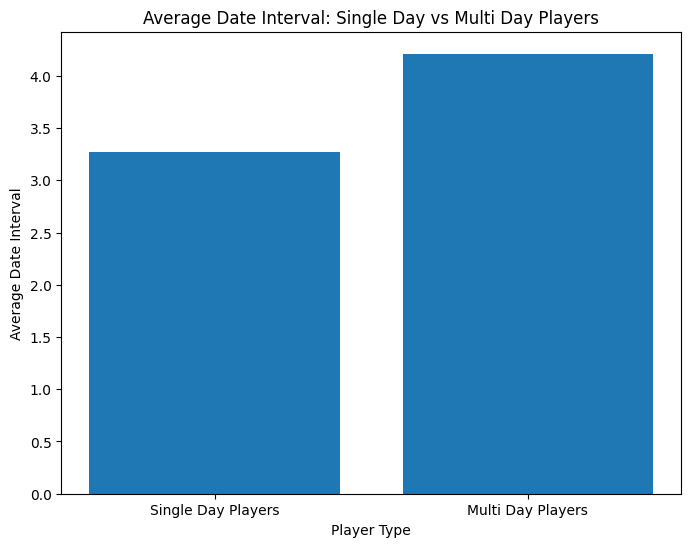

In [72]:
import matplotlib.pyplot as plt

# 두 그룹의 평균 값
intervals = [interval_avg, interval_avg_multi]
labels = ['Single Day Players', 'Multi Day Players']

# 바 플롯 생성
plt.figure(figsize=(8, 6))
plt.bar(labels, intervals)

# 플롯 라벨과 제목 설정
plt.xlabel('Player Type')
plt.ylabel('Average Date Interval')
plt.title('Average Date Interval: Single Day vs Multi Day Players')

# 그래프 출력
plt.show()


## 실제 시간 계산을 통한 실제 시간 중 게임에 사용한 시간 비율 계산

In [105]:
data_dir="../levelups_panel_20240722.csv"
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]

In [106]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot'] = data.groupby('player_slug')['interval_until'].transform('last')

##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['interval_normalized'] = data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until_norm'] = data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot_norm'] = data.groupby('player_slug')['interval_until_norm'].transform('last')


In [107]:
# 'date_event' 컬럼을 datetime 형식으로 변환 (ISO 8601 형식 처리)
data['real_datetime'] = pd.to_datetime(data['event_datetime'])

# player_slug별로 첫 번째와 마지막 event_datetime을 구함
first_last_event = data.groupby('player_slug')['real_datetime'].agg(['min', 'max'])

# 현실 시간 차이 계산 (마지막 시간 - 처음 시간)
first_last_event['real_time_difference'] = first_last_event['max'] - first_last_event['min']


In [108]:
# 현실 시간 차이를 시간으로 변환
first_last_event['real_time_difference_in_hours'] = first_last_event['real_time_difference'].dt.total_seconds() / 3600
# player_slug를 기준으로 병합
data = data.merge(first_last_event[['real_time_difference_in_hours']], on='player_slug', how='left')

# 결과 확인
print(data[['player_slug', 'real_time_difference_in_hours']])

                     player_slug  real_time_difference_in_hours
0       2021-11-01T08:32:01.518Z                      22.534722
1       2021-11-01T08:32:01.518Z                      22.534722
2       2021-11-01T08:32:01.518Z                      22.534722
3       2021-11-01T08:32:01.518Z                      22.534722
4       2021-11-01T08:32:01.518Z                      22.534722
...                          ...                            ...
720616  2022-03-30T06:38:53.434Z                       2.758056
720617  2022-03-30T06:38:53.434Z                       2.758056
720618  2022-03-30T06:38:53.434Z                       2.758056
720619  2022-03-30T06:38:53.434Z                       2.758056
720620  2022-03-30T06:38:53.434Z                       2.758056

[720621 rows x 2 columns]


In [109]:
data_last= data.drop_duplicates(subset='player_slug', keep='last')

In [110]:
# 'interval_tot'을 'real_time_difference_in_seconds'로 나눈 값 계산
data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours']+data_last['interval'])
# 결과 확인
print(data_last['interval_to_real_time_ratio'])

98        0.232419
197       0.890335
296       0.236960
395       0.155147
494       0.032619
            ...   
720224    0.506018
720323    0.313586
720422    0.832996
720521    0.101976
720620    0.816341
Name: interval_to_real_time_ratio, Length: 7279, dtype: float64


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_8308\2373500680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_last['interval_to_real_time_ratio'] = data_last['interval_tot'] / (data_last['real_time_difference_in_hours']+data_last['interval'])


In [111]:
data_last

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio
98,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,drop,99,100,...,17.826389,1,5.450056,5.450056,0.335187,11.974133,11.974133,2021-11-02 17:48:34,22.534722,0.232419
197,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,99,100,...,3.896389,1,3.733222,3.733222,0.188614,8.087390,8.087390,2021-11-01 23:25:34,3.678333,0.890335
296,2021-11-01T14:12:34.729Z,레서판다,71,1,0.0,0.0,102,complete,99,100,...,19.563056,1,3.202056,3.202056,0.000611,9.777074,9.777074,2021-11-02 12:46:47,13.511111,0.236960
395,2021-11-01T15:01:02.831Z,벤쿤,10,0,0.0,0.0,129,complete,99,100,...,23.909722,1,3.455333,3.455333,0.049598,10.479385,10.479385,2021-11-02 22:10:17,22.135833,0.155147
494,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,99,100,...,12.962500,1,4.277167,4.277167,0.091761,11.540296,11.540296,2021-11-07 11:04:01,130.874722,0.032619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720224,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,99,100,...,7.316667,1,3.765056,3.765056,0.220185,10.547885,10.547885,2022-03-28 16:00:04,6.839722,0.506018
720323,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,99,100,...,23.425278,1,8.556278,8.556278,0.024646,15.808379,15.808379,2022-03-29 19:59:04,27.217778,0.313586
720422,2022-03-28T11:06:23.113Z,구또,47,0,122100.0,0.0,124,complete,99,100,...,3.639167,1,2.744722,2.744722,0.054792,8.776578,8.776578,2022-03-28 23:16:32,3.145278,0.832996
720521,2022-03-29T09:29:33.653Z,이가탄,7,0,0.0,6.0,120,complete,99,100,...,5.926667,1,2.445278,2.445278,0.037580,8.377549,8.377549,2022-03-30 18:30:28,23.876111,0.101976


In [116]:
data_last['interval_to_real_time_ratio'].max()

1.4106526010962854

In [118]:
# 'interval_to_real_time_ratio' 컬럼의 최대값 구하기
max_ratio = data_last['interval_to_real_time_ratio'].max()

# 최대값을 가진 데이터 필터링
max_ratio_data = data_last[data_last['interval_to_real_time_ratio'] == max_ratio]

# 결과 출력
max_ratio_data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours,interval_to_real_time_ratio
581822,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,99,100,...,3.092222,0,3.788778,3.788778,0.029025,9.676801,9.676801,2022-03-09 22:22:03,2.606389,1.410653


In [129]:
data[data['player_slug']=='2022-03-09T10:40:35.069Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,real_datetime,real_time_difference_in_hours
581724,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,1,2,...,True,3.092222,0,0.034722,3.788778,0.108830,0.108830,9.676801,2022-03-09 19:45:40,2.606389
581725,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,2,3,...,True,3.092222,0,0.039167,3.788778,0.020801,0.129630,9.676801,2022-03-09 19:45:55,2.606389
581726,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,3,4,...,True,3.092222,0,0.075833,3.788778,0.263158,0.392788,9.676801,2022-03-09 19:48:06,2.606389
581727,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,4,5,...,True,3.092222,0,0.086944,3.788778,0.065257,0.458045,9.676801,2022-03-09 19:48:45,2.606389
581728,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,5,6,...,True,3.092222,0,0.129444,3.788778,0.268398,0.726443,9.676801,2022-03-09 19:51:17,2.606389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581818,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,95,96,...,True,3.092222,0,3.152611,3.788778,0.052975,9.380492,9.676801,2022-03-09 22:11:35,2.606389
581819,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,96,97,...,True,3.092222,0,3.156778,3.788778,0.004232,9.384724,9.676801,2022-03-09 22:11:49,2.606389
581820,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,97,98,...,True,3.092222,0,3.160667,3.788778,0.003391,9.388115,9.676801,2022-03-09 22:12:02,2.606389
581821,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,98,99,...,True,3.092222,0,3.709333,3.788778,0.259661,9.647775,9.676801,2022-03-09 22:17:18,2.606389


In [128]:
check=data[data['player_slug']=='2022-03-09T10:40:35.069Z']
check[['level_from','level_to','interval','interval_until','interval_tot','real_time_difference_in_hours']].tail(50)

,level_from,level_to,interval,interval_until,interval_tot,real_time_difference_in_hours
581773,50,51,0.018056,0.938889,3.788778,2.606389
581774,51,52,0.033889,0.972778,3.788778,2.606389
581775,52,53,0.017222,0.990000,3.788778,2.606389
581776,53,54,0.055000,1.045000,3.788778,2.606389
581777,54,55,0.026389,1.071389,3.788778,2.606389
581778,55,56,0.012500,1.083889,3.788778,2.606389
581779,56,57,0.035000,1.118889,3.788778,2.606389
581780,57,58,0.031111,1.150000,3.788778,2.606389
581781,58,59,0.033611,1.183611,3.788778,2.606389
581782,59,60,0.026944,1.210556,3.788778,2.606389


In [130]:
data_dir="../levelups_panel_20240305.csv"
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]

In [131]:
data[data['player_slug']=='2022-03-09T10:40:35.069Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,event_datetime_prev,interval,interval_cum,playtime_boss,playtime_dungeon,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side
2092900,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,1,2,...,2022-03-09 19:43:36,0.034722,0.034722,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092901,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,2,3,...,2022-03-09 19:45:40,0.004444,0.039167,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092902,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,3,4,...,2022-03-09 19:45:55,0.036667,0.075833,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092903,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,4,5,...,2022-03-09 19:48:06,0.011111,0.086944,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092904,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,5,6,...,2022-03-09 19:48:45,0.042500,0.129444,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092994,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,95,96,...,2022-03-09 22:08:12,0.056667,2.492778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092995,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,96,97,...,2022-03-09 22:11:35,0.004167,2.496944,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092996,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,97,98,...,2022-03-09 22:11:49,0.003889,2.500833,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2092997,2022-03-09T10:40:35.069Z,이도,107,1,0.0,5.0,113,complete,98,99,...,2022-03-09 22:12:02,0.088056,2.588889,0.0,0.0,0.0,0.0,0.0,0.0,0.0
